In [ ]:
import os
import re
import gc
import sys
import time
import json
import random
import unicodedata
import multiprocessing
from functools import partial, lru_cache

import emoji

import numpy as np
import pandas as pd
from sklearn.externals import joblib
from tqdm import tqdm, tqdm_notebook

from nltk import TweetTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences

class SequenceBucketCollator():
    def __init__(self, choose_length, sequence_index, length_index, label_index=None):
        self.choose_length = choose_length
        self.sequence_index = sequence_index
        self.length_index = length_index
        self.label_index = label_index

    def __call__(self, batch):
        batch = [torch.stack(x) for x in list(zip(*batch))]

        sequences = batch[self.sequence_index]
        lengths = batch[self.length_index]

        length = self.choose_length(lengths)
        mask = torch.arange(start=maxlen, end=0, step=-1) < length
        padded_sequences = sequences[:, mask]

        batch[self.sequence_index] = padded_sequences

        if self.label_index is not None:
            return [x for i, x in enumerate(batch) if i != self.label_index], batch[self.label_index]

        return batch


CUSTOM_TABLE = str.maketrans(
    {
        "\xad": None,
        "\x7f": None,
        "\ufeff": None,
        "\u200b": None,
        "\u200e": None,
        "\u202a": None,
        "\u202c": None,
        "‘": "'",
        "’": "'",
        "`": "'",
        "“": '"',
        "”": '"',
        "«": '"',
        "»": '"',
        "ɢ": "G",
        "ɪ": "I",
        "ɴ": "N",
        "ʀ": "R",
        "ʏ": "Y",
        "ʙ": "B",
        "ʜ": "H",
        "ʟ": "L",
        "ғ": "F",
        "ᴀ": "A",
        "ᴄ": "C",
        "ᴅ": "D",
        "ᴇ": "E",
        "ᴊ": "J",
        "ᴋ": "K",
        "ᴍ": "M",
        "Μ": "M",
        "ᴏ": "O",
        "ᴘ": "P",
        "ᴛ": "T",
        "ᴜ": "U",
        "ᴡ": "W",
        "ᴠ": "V",
        "ĸ": "K",
        "в": "B",
        "м": "M",
        "н": "H",
        "т": "T",
        "ѕ": "S",
        "—": "-",
        "–": "-",
    }
)

WORDS_REPLACER = [
    ("sh*t", "shit"),
    ("s**t", "shit"),
    ("f*ck", "fuck"),
    ("fu*k", "fuck"),
    ("f**k", "fuck"),
    ("f*****g", "fucking"),
    ("f***ing", "fucking"),
    ("f**king", "fucking"),
    ("p*ssy", "pussy"),
    ("p***y", "pussy"),
    ("pu**y", "pussy"),
    ("p*ss", "piss"),
    ("b*tch", "bitch"),
    ("bit*h", "bitch"),
    ("h*ll", "hell"),
    ("h**l", "hell"),
    ("cr*p", "crap"),
    ("d*mn", "damn"),
    ("stu*pid", "stupid"),
    ("st*pid", "stupid"),
    ("n*gger", "nigger"),
    ("n***ga", "nigger"),
    ("f*ggot", "faggot"),
    ("scr*w", "screw"),
    ("pr*ck", "prick"),
    ("g*d", "god"),
    ("s*x", "sex"),
    ("a*s", "ass"),
    ("a**hole", "asshole"),
    ("a***ole", "asshole"),
    ("a**", "ass"),
]

REGEX_REPLACER = [
    (re.compile(pat.replace("*", "\*"), flags=re.IGNORECASE), repl)
    for pat, repl in WORDS_REPLACER
]

RE_SPACE = re.compile(r"\s")
RE_MULTI_SPACE = re.compile(r"\s+")

NMS_TABLE = dict.fromkeys(
    i for i in range(sys.maxunicode + 1) if unicodedata.category(chr(i)) == "Mn"
)

HEBREW_TABLE = {i: "א" for i in range(0x0590, 0x05FF)}
ARABIC_TABLE = {i: "ا" for i in range(0x0600, 0x06FF)}
CHINESE_TABLE = {i: "是" for i in range(0x4E00, 0x9FFF)}
KANJI_TABLE = {i: "ッ" for i in range(0x2E80, 0x2FD5)}
HIRAGANA_TABLE = {i: "ッ" for i in range(0x3041, 0x3096)}
KATAKANA_TABLE = {i: "ッ" for i in range(0x30A0, 0x30FF)}

TABLE = dict()
TABLE.update(CUSTOM_TABLE)
TABLE.update(NMS_TABLE)
# Non-english languages
TABLE.update(CHINESE_TABLE)
TABLE.update(HEBREW_TABLE)
TABLE.update(ARABIC_TABLE)
TABLE.update(HIRAGANA_TABLE)
TABLE.update(KATAKANA_TABLE)
TABLE.update(KANJI_TABLE)


EMOJI_REGEXP = emoji.get_emoji_regexp()

UNICODE_EMOJI_MY = {
    k: f" EMJ {v.strip(':').replace('_', ' ')} "
    for k, v in emoji.UNICODE_EMOJI_ALIAS.items()
}


def my_demojize(string: str) -> str:
    def replace(match):
        return UNICODE_EMOJI_MY.get(match.group(0), match.group(0))

    return re.sub("\ufe0f", "", EMOJI_REGEXP.sub(replace, string))


def normalize(text: str) -> str:
    text = my_demojize(text)

    text = RE_SPACE.sub(" ", text)
    text = unicodedata.normalize("NFKD", text)
    text = text.translate(TABLE)
    text = RE_MULTI_SPACE.sub(" ", text).strip()

    for pattern, repl in REGEX_REPLACER:
        text = pattern.sub(repl, text)

    return text


PORTER_STEMMER = PorterStemmer()
LANCASTER_STEMMER = LancasterStemmer()
SNOWBALL_STEMMER = SnowballStemmer("english")

def word_forms(word):
    yield word
    yield word.lower()
    yield word.upper()
    yield word.capitalize()
    yield PORTER_STEMMER.stem(word)
    yield LANCASTER_STEMMER.stem(word)
    yield SNOWBALL_STEMMER.stem(word)

def maybe_get_embedding(word, model):
    for form in word_forms(word):
        if form in model:
            return model[form]

    word = word.strip("-'")
    for form in word_forms(word):
        if form in model:
            return model[form]

    return None


def gensim_to_embedding_matrix(word2index, path):
    model = KeyedVectors.load(path, mmap="r")
    embedding_matrix = np.zeros((max(word2index.values()) + 1, model.vector_size), dtype=np.float32)
    unknown_words = []

    for word, i in word2index.items():
        maybe_embedding = maybe_get_embedding(word, model)
        if maybe_embedding is not None:
            embedding_matrix[i] = maybe_embedding
        else:
            unknown_words.append(word)

    return embedding_matrix, unknown_words

Using TensorFlow backend.


In [ ]:
print (emoji.__version__)

0.5.2


In [ ]:
%%time

test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

CPU times: user 290 ms, sys: 59.3 ms, total: 350 ms
Wall time: 686 ms


In [ ]:
# test = test.head(1000)

In [ ]:
test.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [ ]:
test2 = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv')
test2.head()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,identity_annotator_count,toxicity_annotator_count,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
0,7000000,Jeff Sessions is another one of Trump's Orwell...,2017-01-26 07:37:38.422417+00,13,NaN,164149,approved,0,0,0,4,0,0.200000,0.0,0.000000,0.0,0.0,0.200000,0.0,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7000001,I actually inspected the infrastructure on Gra...,2016-12-03 20:38:21.204649+00,54,655260.0,154341,approved,0,0,0,2,4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7000002,No it won't . That's just wishful thinking on ...,2017-05-05 18:07:58.560078+00,21,5219683.0,332005,approved,0,0,0,0,4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7000003,Instead of wringing our hands and nibbling the...,2017-02-09 14:46:30.189044+00,13,NaN,167110,approved,0,0,1,12,0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7000004,how many of you commenters have garbage piled ...,2016-10-15 01:18:40.521923+00,21,NaN,148484,approved,0,0,0,2,0,0.753846,0.0,0.046154,0.0,0.0,0.723077,0.0,0,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
%%time
with multiprocessing.Pool(processes=2) as pool:
     text_list = pool.map(normalize, test.comment_text.tolist())

CPU times: user 147 ms, sys: 111 ms, total: 258 ms
Wall time: 1min 3s


In [ ]:
%%time
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

test_word_sequences = []
word_dict = {}
word_index = 1

for doc in text_list:
    word_seq = []
    for token in tknzr.tokenize(doc):
        if token not in word_dict:
            word_dict[token] = word_index
            word_index += 1
        word_seq.append(word_dict[token])
    test_word_sequences.append(word_seq)

CPU times: user 43.7 s, sys: 72 ms, total: 43.8 s
Wall time: 43.8 s


In [ ]:
%%time

test_lengths = torch.from_numpy(np.array([len(x) for x in test_word_sequences]))
maxlen = test_lengths.max()
print(f"Max len = {maxlen}")
maxlen = min(maxlen, 400)

x_test_padded = torch.tensor(pad_sequences(test_word_sequences, maxlen=maxlen)).long()
test_collator = SequenceBucketCollator(torch.max, sequence_index=0, length_index=1)

del text_list, test_word_sequences, tknzr
gc.collect()

Max len = 311
CPU times: user 2.82 s, sys: 225 ms, total: 3.05 s
Wall time: 2.94 s


In [ ]:
%%time

glove_matrix, _ = gensim_to_embedding_matrix(
    word_dict,
    "../input/gensim-embeddings-dataset/glove.840B.300d.gensim",
)

crawl_matrix, _ = gensim_to_embedding_matrix(
    word_dict,
    "../input/gensim-embeddings-dataset/crawl-300d-2M.gensim",
)

para_matrix, _ = gensim_to_embedding_matrix(
    word_dict,
    "../input/gensim-embeddings-dataset/paragram_300_sl999.gensim",
)

w2v_matrix, _ = gensim_to_embedding_matrix(
    word_dict,
    "../input/gensim-embeddings-dataset/GoogleNews-vectors-negative300.gensim",
)

/opt/conda/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/opt/conda/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/opt/conda/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'Se

CPU times: user 45.7 s, sys: 6.01 s, total: 51.7 s
Wall time: 3min 44s


In [ ]:
%%time

def one_hot_char_embeddings(word2index, char_vectorizer):
    words = [""] * (max(word2index.values()) + 1)
    for word, i in word2index.items():
        words[i] = word

    return char_vectorizer.transform(words).toarray().astype(np.float32)

char_matrix = one_hot_char_embeddings(
    word_dict,
    joblib.load('../input/jigsaw-solution-ver-1/char_vectorizer.pkl'),
)

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.0 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


CPU times: user 1.46 s, sys: 63.7 ms, total: 1.52 s
Wall time: 1.54 s


In [ ]:
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 6 * LSTM_UNITS

class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)
        x = x.permute(0, 3, 2, 1)
        x = super(SpatialDropout, self).forward(x)
        x = x.permute(0, 3, 2, 1)
        x = x.squeeze(2)
        return x


class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, output_aux_sub=11):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]

        self.embedding = nn.Embedding(embedding_matrix.shape[0], embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)

        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)

        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS + 6 + output_aux_sub, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, 6)
        self.linear_sub_out = nn.Linear(DENSE_HIDDEN_UNITS, output_aux_sub)

    def forward(self, x, lengths=None):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)

        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)

        avg_pool1 = torch.mean(h_lstm1, 1)
        avg_pool2 = torch.mean(h_lstm2, 1)
        max_pool2, _ = torch.max(h_lstm2, 1)

        h_conc = torch.cat((avg_pool1, max_pool2, avg_pool2), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))

        hidden = h_conc + h_conc_linear1 + h_conc_linear2

        aux_result = self.linear_aux_out(hidden)
        sub_result = self.linear_sub_out(hidden)
        result = self.linear_out(torch.cat((hidden, aux_result, sub_result), 1))
        out = torch.cat([result, aux_result, sub_result], 1)
        return out


def get_lstm_preds(model_name, embedding_matrix):
    model = NeuralNet(embedding_matrix)
    temp_dict = torch.load('../input/jigsaw-solution-ver-1/' + model_name)
    temp_dict['embedding.weight'] = torch.tensor(embedding_matrix)
    model.load_state_dict(temp_dict)
    model = model.cuda()
    for param in model.parameters():
        param.requires_grad=False
    model = model.eval()

    batch_size = 256
    test_dataset = data.TensorDataset(x_test_padded, test_lengths)
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=test_collator)

    preds = np.zeros((len(test_dataset), 18), dtype=np.float32)
    with torch.no_grad():
        for i, (x_batch) in enumerate(test_loader):
            X_1 = x_batch[0].cuda()
            y_pred = torch.sigmoid(model(X_1)).cpu().numpy()
            preds[i * batch_size:(i + 1) * batch_size] = y_pred

    return preds

# LSTM inference

In [ ]:
%%time

lstm_models = ['Notebook_100_5.bin',
               'Notebook_100_6.bin',
               'Notebook_100_7.bin',
               'Notebook_100_8.bin',
               'Notebook_100_9.bin',
               'Notebook_100_10.bin',
               'Notebook_100_11.bin',
               'Notebook_100_12.bin']

embedding_matrix = np.concatenate([glove_matrix, crawl_matrix, w2v_matrix, char_matrix], axis=1)

all_lstm_preds = []
for model_name in lstm_models:
    print(model_name)
    preds = get_lstm_preds(model_name, embedding_matrix)
    all_lstm_preds.append(preds)
    gc.collect()

Notebook_100_5.bin
Notebook_100_6.bin
Notebook_100_7.bin
Notebook_100_8.bin
Notebook_100_9.bin
Notebook_100_10.bin
Notebook_100_11.bin
Notebook_100_12.bin
CPU times: user 3min, sys: 6.96 s, total: 3min 7s
Wall time: 2min 24s


In [ ]:
print(embedding_matrix.dtype)

float32


In [ ]:
# lstm_models = ['Notebook_100_13.bin']

# embedding_matrix = np.concatenate([glove_matrix, crawl_matrix, para_matrix, char_matrix], axis=1)

# for model_name in lstm_models:
#     print(model_name)
#     preds = get_lstm_preds(model_name, embedding_matrix)
#     all_lstm_preds.append(preds)
#     gc.collect()

In [ ]:
%%time

lstm_models = ['Notebook_100_1.bin']

embedding_matrix = np.concatenate([para_matrix, crawl_matrix, w2v_matrix, char_matrix], axis=1)

for model_name in lstm_models:
    print(model_name)
    preds = get_lstm_preds(model_name, embedding_matrix)
    all_lstm_preds.append(preds)

lstm_models = ['Notebook_100_2.bin']

embedding_matrix = np.concatenate([glove_matrix, crawl_matrix, w2v_matrix, char_matrix], axis=1)

for model_name in lstm_models:
    print(model_name)
    preds = get_lstm_preds(model_name, embedding_matrix)
    all_lstm_preds.append(preds)

lstm_models = ['Notebook_100_3.bin']

embedding_matrix = np.concatenate([glove_matrix, para_matrix, w2v_matrix, char_matrix], axis=1)

for model_name in lstm_models:
    print(model_name)
    preds = get_lstm_preds(model_name, embedding_matrix)
    all_lstm_preds.append(preds)

lstm_models = ['Notebook_100_4.bin']

embedding_matrix = np.concatenate([glove_matrix, para_matrix, crawl_matrix, char_matrix], axis=1)

for model_name in lstm_models:
    print(model_name)
    preds = get_lstm_preds(model_name, embedding_matrix)
    all_lstm_preds.append(preds)

Notebook_100_1.bin
Notebook_100_2.bin
Notebook_100_3.bin
Notebook_100_4.bin
CPU times: user 1min 29s, sys: 3.72 s, total: 1min 33s
Wall time: 1min 10s


In [ ]:
def simple_magic(preds):
    return (
        preds[:, 0] + preds[:, 1] * 0.05 - preds[:, -1] * 0.05 - preds[:, 4] * 0.05
    )

def sophisticated_magic(preds):
    return (
        preds[:, 0] + preds[:, 1] * 0.05 - preds[:, -1] * 0.03 - preds[:, 4] * 0.03
    ) - preds[:, 14] * (1 - preds[:, 0]) * 0.05 - preds[:, 10] * (1 - preds[:, 0]) * 0.05

In [ ]:
# from scipy import stats

all_lstm_preds = np.vstack([sophisticated_magic(x) for x in all_lstm_preds])
# preds_lstm = np.median(all_lstm_preds, axis=0)  # MEDIAN ensemble
# preds_lstm = stats.trim_mean(all_lstm_preds, 0.1, axis=0) # 10%-trimmed-mean

In [ ]:
STORE = {
    'lstm': all_lstm_preds.mean(0),
}

In [ ]:
del crawl_matrix, glove_matrix, para_matrix, w2v_matrix, embedding_matrix
del test_lengths, maxlen, x_test_padded, test_collator
del lstm_models, all_lstm_preds
del word_dict, word_index
gc.collect()

0

# BERT inference

In [ ]:
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertForSequenceClassification

UNCASED_BERT_MODEL_PATH = "../input/transformer-tokenizers/bert-base-uncased/"
CASED_BERT_MODEL_PATH = "../input/transformer-tokenizers/bert-base-cased/"


def clip_to_max_len(batch):
    X, lengths = map(torch.stack, zip(*batch))
    max_len = torch.max(lengths).item()
    return X[:, :max_len]

def prepare_bert(bin_file, is_cased):
    bert_path = CASED_BERT_MODEL_PATH if is_cased else UNCASED_BERT_MODEL_PATH
    config = BertConfig(os.path.join(bert_path, "bert_config.json"))
    model = BertForSequenceClassification(config, num_labels=18)
    model.load_state_dict(torch.load(bin_file, map_location="cpu"))
    for p in model.parameters():
        p.requires_grad = False
    model = model.eval()
    model = model.cuda()
    return model

def prepare_tokenizer(is_cased):
    if is_cased:
        return BertTokenizer.from_pretrained(CASED_BERT_MODEL_PATH, do_lower_case=False)
    else:
        return BertTokenizer.from_pretrained(UNCASED_BERT_MODEL_PATH, do_lower_case=True)


def apply_bert(model, loader):
    preds = np.zeros((len(loader.dataset), 18), dtype=np.float32)
    for i, X in enumerate(loader):
        X = X.cuda()
        p = torch.sigmoid(model(X, attention_mask=(X > 0)))
        preds[i * loader.batch_size : (i + 1) * loader.batch_size] = p.cpu().numpy()
    return preds

## UNCASED

In [ ]:
%%time
tokenizer = prepare_tokenizer(is_cased=False)
MAX_LEN = 400 - 2

def convert_line(text):
    tokens_a = tokenizer.tokenize(text)[:MAX_LEN]
    one_token = tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens_a + ["[SEP]"])
    one_token += [0] * (MAX_LEN - len(tokens_a))
    return one_token

with multiprocessing.Pool(processes=2) as pool:
    sequences = pool.map(convert_line, test.comment_text)
sequences = np.array(sequences)

lengths = np.argmax(sequences == 0, axis=1)
lengths[lengths == 0] = sequences.shape[1]

ids = lengths.argsort(kind="stable")
inverse_ids = test.id.values[ids].argsort(kind="stable")

sequences = torch.from_numpy(sequences)
lengths = torch.from_numpy(lengths)

test_dataset = data.TensorDataset(sequences, lengths)
test_loader = data.DataLoader(data.Subset(test_dataset, ids), batch_size=128, collate_fn=clip_to_max_len)

CPU times: user 10.4 s, sys: 756 ms, total: 11.2 s
Wall time: 1min 38s


In [ ]:
%%time

UNCASED_BERT_MODELS = [
    "BERT_exp_BERT_3_decay_5_epoch_1",
    "final-pipe1-raw_1",
    "final-pipe1-raw_2",
    "final-pipe1-raw_3",
    "final-pipe2-raw_1",
    "final-pipe2-raw_2",
    "final-pipe2-raw_3",
    "final-pipe4-wiki_raw_1",
    "final-pipe4-wiki_raw_2",
    "final-pipe4-wiki_raw_3",
]

for path in UNCASED_BERT_MODELS:
    model = prepare_bert(f"../input/toxic-models-zoo/{path}.bin", is_cased=False)
    preds = apply_bert(model, test_loader)
    STORE[path] = sophisticated_magic(preds)[inverse_ids]


for path in ["final-pipe2-raw_4", "BERT_exp_BERT_3_epoch_1"]:
    model = prepare_bert(f"../input/jigsaw-solution-ver-1/{path}.bin", is_cased=False)
    preds = apply_bert(model, test_loader)
    STORE[path] = sophisticated_magic(preds)[inverse_ids]

CPU times: user 43min 9s, sys: 4.81 s, total: 43min 14s
Wall time: 44min 10s


## CASED

In [ ]:
%%time
tokenizer = prepare_tokenizer(is_cased=True)

def convert_line(text):
    tokens_a = tokenizer.tokenize(text)[:MAX_LEN]
    one_token = tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens_a + ["[SEP]"])
    one_token += [0] * (MAX_LEN - len(tokens_a))
    return one_token

with multiprocessing.Pool(processes=2) as pool:
    sequences = pool.map(convert_line, test.comment_text)
sequences = np.array(sequences)

lengths = np.argmax(sequences == 0, axis=1)
lengths[lengths == 0] = sequences.shape[1]

ids = lengths.argsort(kind="stable")
inverse_ids = test.id.values[ids].argsort(kind="stable")

sequences = torch.from_numpy(sequences)
lengths = torch.from_numpy(lengths)

test_dataset = data.TensorDataset(sequences, lengths)
test_loader = data.DataLoader(data.Subset(test_dataset, ids), batch_size=128, collate_fn=clip_to_max_len)

CPU times: user 10.2 s, sys: 825 ms, total: 11.1 s
Wall time: 1min 27s


In [ ]:
%%time

CASED_BERT_MODELS = [
    "BERT_exp_BERT_3_cased_decay_epoch_1",
    "final-pipe2-cased_1",
    "final-pipe2-cased_2",
    "final-pipe2-cased_3",
#     "final-pipe2-cased_4",
#     "final-pipe2-cased_5",
#     "final-pipe2-cased_6",
    "final-pipe5-wiki_cased_1",
    "final-pipe5-wiki_cased_2",
    "final-pipe5-wiki_cased_3",
]

for path in CASED_BERT_MODELS:
    model = prepare_bert(f"../input/toxic-models-zoo/{path}.bin", is_cased=True)
    preds = apply_bert(model, test_loader)
    STORE[path] = sophisticated_magic(preds)[inverse_ids]


for path in ["final-pipe2-cased_10"]:
    model = prepare_bert(f"../input/jigsaw-solution-ver-1/{path}.bin", is_cased=True)
    preds = apply_bert(model, test_loader)
    STORE[path] = sophisticated_magic(preds)[inverse_ids]

CPU times: user 29min 41s, sys: 3.1 s, total: 29min 44s
Wall time: 30min 22s


## GPT2CNN

In [ ]:
import regex as re
from io import open

@lru_cache()
def bytes_to_unicode():
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

def get_pairs(word):
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

class MonkeyPatchedGPT2Tokenizer(object):
    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, cache_dir=None, *inputs, **kwargs):
        vocab_file = os.path.join(pretrained_model_name_or_path, "vocab.json")
        merges_file = os.path.join(pretrained_model_name_or_path, "merges.txt")

        max_len = 1024
        kwargs['max_len'] = min(kwargs.get('max_len', int(1e12)), max_len)
        # Instantiate tokenizer.
        special_tokens = kwargs.pop('special_tokens', [])
        tokenizer = cls(vocab_file, merges_file, special_tokens=special_tokens, *inputs, **kwargs)
        return tokenizer

    def __init__(self, vocab_file, merges_file, errors='replace', special_tokens=None, max_len=None):
        self.max_len = max_len if max_len is not None else int(1e12)
        self.encoder = json.load(open(vocab_file))
        self.decoder = {v:k for k,v in self.encoder.items()}
        self.errors = errors # how to handle errors in decoding
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v:k for k, v in self.byte_encoder.items()}
        bpe_data = open(merges_file, encoding='utf-8').read().split('\n')[1:-1]
        bpe_merges = [tuple(merge.split()) for merge in bpe_data]
        self.bpe_ranks = dict(zip(bpe_merges, range(len(bpe_merges))))
        self.cache = {}

        # Should haved added re.IGNORECASE so BPE merges can happen for capitalized  of contractions
        self.pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

        self.special_tokens = {}
        self.special_tokens_decoder = {}
        self.set_special_tokens(special_tokens)

    def __len__(self):
        return len(self.encoder) + len(self.special_tokens)

    def set_special_tokens(self, special_tokens):
        if not special_tokens:
            self.special_tokens = {}
            self.special_tokens_decoder = {}
            return
        self.special_tokens = dict((tok, len(self.encoder) + i) for i, tok in enumerate(special_tokens))
        self.special_tokens_decoder = {v:k for k, v in self.special_tokens.items()}

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token)
        pairs = get_pairs(word)

        if not pairs:
            return token

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def tokenize(self, text):
        bpe_tokens = []
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(bpe_token for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def convert_tokens_to_ids(self, tokens):
        ids = []
        if isinstance(tokens, str):
            if tokens in self.special_tokens:
                return self.special_tokens[tokens]
            else:
                return self.encoder.get(tokens, 0)
        for token in tokens:
            if token in self.special_tokens:
                ids.append(self.special_tokens[token])
            else:
                ids.append(self.encoder.get(token, 0))
        if len(ids) > self.max_len:
            print(
                "Token indices sequence length is longer than the specified maximum "
                " sequence length for this OpenAI GPT model ({} > {}). Running this"
                " sequence through the model will result in indexing errors".format(len(ids), self.max_len)
            )
        return ids

    def convert_ids_to_tokens(self, ids, skip_special_tokens=False):
        """Converts a sequence of ids in BPE tokens using the vocab."""
        tokens = []
        for i in ids:
            if i in self.special_tokens_decoder:
                if not skip_special_tokens:
                    tokens.append(self.special_tokens_decoder[i])
            else:
                tokens.append(self.decoder[i])
        return tokens

    def encode(self, text):
        return self.convert_tokens_to_ids(self.tokenize(text))

    def decode(self, tokens, skip_special_tokens=False, clean_up_tokenization_spaces=True):
        text = ''.join(self.convert_ids_to_tokens(tokens, skip_special_tokens=skip_special_tokens))
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors=self.errors)
        if clean_up_tokenization_spaces:
            text = text.replace('<unk>', '')
            text = text.replace(' .', '.').replace(' ?', '?').replace(' !', '!').replace(' ,', ','
                    ).replace(" ' ", "'").replace(" n't", "n't").replace(" 'm", "'m").replace(" do not", " don't"
                    ).replace(" 's", "'s").replace(" 've", "'ve").replace(" 're", "'re")
        return text


In [ ]:
from pytorch_pretrained_bert import GPT2Config, GPT2Model
from pytorch_pretrained_bert.modeling_gpt2 import GPT2PreTrainedModel

MAX_LEN = 250
GPT2_TOKENIZER = MonkeyPatchedGPT2Tokenizer.from_pretrained("../input/transformer-tokenizers/gpt2/")

def convert_line_gpt2(text):
    tokens_a = GPT2_TOKENIZER.tokenize(text)[:MAX_LEN]
    one_token = GPT2_TOKENIZER.convert_tokens_to_ids(tokens_a)
    one_token += [0] * (MAX_LEN - len(tokens_a))
    return one_token


def apply_gpt(model, loader):
    preds = np.zeros((len(loader.dataset), 18), dtype=np.float32)
    for i, X in enumerate(loader):
        p = torch.sigmoid(model(X.cuda()))
        preds[i * loader.batch_size : (i + 1) * loader.batch_size] = p.cpu().numpy()
    return preds


class GPT2CNN(GPT2PreTrainedModel):
    def __init__(self, config, num_labels):
        super().__init__(config)
        self.transformer = GPT2Model(config)
        self.cnn1 = nn.Conv1d(768, 256, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(256, num_labels, kernel_size=3, padding=1)
        self.apply(self.init_weights)

    def forward(self, input_ids, position_ids=None, token_type_ids=None, lm_labels=None, past=None):
        x, _ = self.transformer(input_ids, position_ids, token_type_ids, past)
        x = x.permute(0, 2, 1)
        x = F.relu(self.cnn1(x))
        x = self.cnn2(x)
        output, _ = torch.max(x, 2)
        return output

In [ ]:
%%time
with multiprocessing.Pool(processes=2) as pool:
    sequences = np.array(pool.map(convert_line_gpt2, test.comment_text))

lengths = np.argmax(sequences == 0, axis=1)
lengths[lengths == 0] = sequences.shape[1]

sequences = torch.from_numpy(sequences)
lengths = torch.from_numpy(lengths)

test_dataset = data.TensorDataset(sequences, lengths)
test_loader = data.DataLoader(test_dataset, batch_size=64, collate_fn=clip_to_max_len)

CPU times: user 6.46 s, sys: 567 ms, total: 7.03 s
Wall time: 32.2 s


In [ ]:
%%time

GPT2CNN_MODELS = [
    "BERT_exp_GPT2_CNN_epoch_1",
    "BERT_exp_GPT2_CNN_seed_epoch_1",
#     "final-pipe6-gpt_wiki_1",
]

for path in GPT2CNN_MODELS:
    model = GPT2CNN(GPT2Config(), num_labels=18)
    model.load_state_dict(
        torch.load(f"../input/toxic-models-zoo/{path}.bin", map_location="cpu")
    )
    for p in model.parameters():
        p.requires_grad = False
    model = model.eval()
    model = model.cuda()
    preds = apply_gpt(model, test_loader)
    STORE[path] = sophisticated_magic(preds)

CPU times: user 27min 18s, sys: 1.38 s, total: 27min 19s
Wall time: 27min 18s


# MERGING

In [ ]:
df = pd.DataFrame(STORE)

In [ ]:
df.head()

,lstm,BERT_exp_BERT_3_decay_5_epoch_1,final-pipe1-raw_1,final-pipe1-raw_2,final-pipe1-raw_3,final-pipe2-raw_1,final-pipe2-raw_2,final-pipe2-raw_3,final-pipe4-wiki_raw_1,final-pipe4-wiki_raw_2,final-pipe4-wiki_raw_3,final-pipe2-raw_4,BERT_exp_BERT_3_epoch_1,BERT_exp_BERT_3_cased_decay_epoch_1,final-pipe2-cased_1,final-pipe2-cased_2,final-pipe2-cased_3,final-pipe5-wiki_cased_1,final-pipe5-wiki_cased_2,final-pipe5-wiki_cased_3,final-pipe2-cased_10,BERT_exp_GPT2_CNN_epoch_1,BERT_exp_GPT2_CNN_seed_epoch_1
0,0.012383,0.012476,0.011094,0.010217,0.010393,0.011287,0.010096,0.008282,0.009567,0.007860,0.010913,0.006531,0.010048,0.011942,0.005527,0.006158,0.006550,0.008221,0.006656,0.005368,0.008734,0.008891,0.007743
1,0.081519,0.088579,0.086486,0.074330,0.092897,0.082421,0.091878,0.077198,0.101560,0.083248,0.105542,0.087636,0.096387,0.077366,0.070397,0.084659,0.072126,0.089732,0.066629,0.067531,0.065960,0.106863,0.125449
2,0.349261,0.353265,0.320458,0.329532,0.321700,0.338747,0.355912,0.346069,0.264668,0.297421,0.334132,0.291985,0.322148,0.258779,0.233789,0.202783,0.245383,0.192864,0.327538,0.214886,0.217010,0.266835,0.276162
3,0.041394,0.052269,0.069734,0.053456,0.046692,0.055645,0.052034,0.042089,0.055890,0.055489,0.060314,0.042380,0.040038,0.051102,0.048257,0.056114,0.042320,0.047534,0.076478,0.062260,0.055633,0.057787,0.043571
4,0.013125,0.022547,0.026367,0.034699,0.037320,0.025701,0.024074,0.016147,0.031278,0.032585,0.024058,0.012134,0.014659,0.019971,0.018601,0.009935,0.019239,0.021898,0.011961,0.022589,0.025586,0.007670,0.010253


In [ ]:
df.corr()

,lstm,BERT_exp_BERT_3_decay_5_epoch_1,final-pipe1-raw_1,final-pipe1-raw_2,final-pipe1-raw_3,final-pipe2-raw_1,final-pipe2-raw_2,final-pipe2-raw_3,final-pipe4-wiki_raw_1,final-pipe4-wiki_raw_2,final-pipe4-wiki_raw_3,final-pipe2-raw_4,BERT_exp_BERT_3_epoch_1,BERT_exp_BERT_3_cased_decay_epoch_1,final-pipe2-cased_1,final-pipe2-cased_2,final-pipe2-cased_3,final-pipe5-wiki_cased_1,final-pipe5-wiki_cased_2,final-pipe5-wiki_cased_3,final-pipe2-cased_10,BERT_exp_GPT2_CNN_epoch_1,BERT_exp_GPT2_CNN_seed_epoch_1
lstm,1.000000,0.969450,0.969161,0.969274,0.970152,0.968926,0.968380,0.969601,0.969940,0.969398,0.969386,0.968493,0.970309,0.968216,0.970352,0.969861,0.969917,0.969650,0.970042,0.970168,0.969065,0.969316,0.968998
BERT_exp_BERT_3_decay_5_epoch_1,0.969450,1.000000,0.992682,0.992108,0.992735,0.989387,0.988778,0.989527,0.992526,0.991884,0.992203,0.988223,0.990316,0.979770,0.980338,0.980307,0.980777,0.980165,0.980100,0.980323,0.979112,0.972000,0.971376
final-pipe1-raw_1,0.969161,0.992682,1.000000,0.992598,0.993055,0.990246,0.989669,0.990071,0.992834,0.992176,0.992764,0.988826,0.990123,0.979553,0.980942,0.980939,0.981242,0.980711,0.980844,0.980862,0.979554,0.971961,0.971356
final-pipe1-raw_2,0.969274,0.992108,0.992598,1.000000,0.992739,0.989777,0.989214,0.989752,0.992355,0.992263,0.992273,0.988831,0.989554,0.979355,0.980863,0.980794,0.980872,0.980520,0.980667,0.980682,0.979486,0.971626,0.971007
final-pipe1-raw_3,0.970152,0.992735,0.993055,0.992739,1.000000,0.990079,0.989467,0.989986,0.992824,0.992432,0.993024,0.988771,0.990367,0.979750,0.981242,0.981281,0.981615,0.980880,0.981124,0.981194,0.979778,0.972392,0.971649
final-pipe2-raw_1,0.968926,0.989387,0.990246,0.989777,0.990079,1.000000,0.991962,0.992348,0.989888,0.989734,0.989932,0.991191,0.991937,0.980074,0.981564,0.981680,0.982056,0.981424,0.981555,0.981521,0.980367,0.973138,0.972744
final-pipe2-raw_2,0.968380,0.988778,0.989669,0.989214,0.989467,0.991962,1.000000,0.991956,0.989185,0.989017,0.989401,0.990907,0.991206,0.979951,0.981352,0.981650,0.981834,0.981231,0.981484,0.981417,0.980401,0.973306,0.972834
final-pipe2-raw_3,0.969601,0.989527,0.990071,0.989752,0.989986,0.992348,0.991956,1.000000,0.990031,0.989583,0.989864,0.991165,0.992054,0.979998,0.981372,0.981751,0.981880,0.981258,0.981398,0.981351,0.980286,0.972910,0.972583
final-pipe4-wiki_raw_1,0.969940,0.992526,0.992834,0.992355,0.992824,0.989888,0.989185,0.990031,1.000000,0.992605,0.992809,0.988827,0.990204,0.979535,0.980884,0.981019,0.981136,0.980869,0.980873,0.980959,0.979546,0.971726,0.971218
final-pipe4-wiki_raw_2,0.969398,0.991884,0.992176,0.992263,0.992432,0.989734,0.989017,0.989583,0.992605,1.000000,0.992488,0.988546,0.989591,0.979312,0.980743,0.980866,0.981156,0.980747,0.980809,0.980812,0.979355,0.971606,0.971064


In [ ]:
df.corr('kendall')

,lstm,BERT_exp_BERT_3_decay_5_epoch_1,final-pipe1-raw_1,final-pipe1-raw_2,final-pipe1-raw_3,final-pipe2-raw_1,final-pipe2-raw_2,final-pipe2-raw_3,final-pipe4-wiki_raw_1,final-pipe4-wiki_raw_2,final-pipe4-wiki_raw_3,final-pipe2-raw_4,BERT_exp_BERT_3_epoch_1,BERT_exp_BERT_3_cased_decay_epoch_1,final-pipe2-cased_1,final-pipe2-cased_2,final-pipe2-cased_3,final-pipe5-wiki_cased_1,final-pipe5-wiki_cased_2,final-pipe5-wiki_cased_3,final-pipe2-cased_10,BERT_exp_GPT2_CNN_epoch_1,BERT_exp_GPT2_CNN_seed_epoch_1
lstm,1.000000,0.806990,0.807711,0.808439,0.809190,0.806045,0.806474,0.806853,0.806380,0.805461,0.804249,0.803756,0.809317,0.804277,0.809930,0.809733,0.808587,0.805084,0.806114,0.805870,0.807446,0.811452,0.812112
BERT_exp_BERT_3_decay_5_epoch_1,0.806990,1.000000,0.908482,0.904823,0.908004,0.888403,0.885999,0.889489,0.904472,0.899412,0.901883,0.882280,0.891546,0.849622,0.852054,0.852460,0.851922,0.850317,0.849869,0.849669,0.847389,0.826767,0.827394
final-pipe1-raw_1,0.807711,0.908482,1.000000,0.908140,0.911034,0.891609,0.889217,0.891807,0.906177,0.902215,0.904847,0.885303,0.889776,0.848055,0.853712,0.854265,0.853838,0.852047,0.851872,0.851820,0.849091,0.826036,0.826654
final-pipe1-raw_2,0.808439,0.904823,0.908140,1.000000,0.908773,0.890085,0.887989,0.890543,0.903631,0.901207,0.901687,0.885158,0.886554,0.848332,0.853072,0.854345,0.853852,0.851605,0.851446,0.850658,0.849410,0.825881,0.826499
final-pipe1-raw_3,0.809190,0.908004,0.911034,0.908773,1.000000,0.892997,0.890282,0.892992,0.906595,0.904317,0.906661,0.886347,0.890928,0.849205,0.855006,0.856488,0.855840,0.853060,0.853480,0.852893,0.851066,0.826834,0.827519
final-pipe2-raw_1,0.806045,0.888403,0.891609,0.890085,0.892997,1.000000,0.900177,0.904032,0.888330,0.885870,0.887361,0.894502,0.900654,0.849502,0.855018,0.855904,0.856051,0.853149,0.852943,0.852299,0.850682,0.825413,0.826050
final-pipe2-raw_2,0.806474,0.885999,0.889217,0.887989,0.890282,0.900177,1.000000,0.901281,0.885890,0.884451,0.884942,0.892862,0.894597,0.847476,0.853384,0.854269,0.853989,0.851121,0.851525,0.850733,0.850135,0.823445,0.824052
final-pipe2-raw_3,0.806853,0.889489,0.891807,0.890543,0.892992,0.904032,0.901281,1.000000,0.888387,0.886277,0.886662,0.895967,0.899611,0.848929,0.854534,0.855426,0.855193,0.852296,0.851789,0.851812,0.850066,0.824968,0.825644
final-pipe4-wiki_raw_1,0.806380,0.904472,0.906177,0.903631,0.906595,0.888330,0.885890,0.888387,1.000000,0.906275,0.906939,0.882639,0.886186,0.845827,0.852044,0.852510,0.851869,0.853302,0.853201,0.853190,0.847535,0.823747,0.824667
final-pipe4-wiki_raw_2,0.805461,0.899412,0.902215,0.901207,0.904317,0.885870,0.884451,0.886277,0.906275,1.000000,0.905052,0.881541,0.883277,0.844880,0.849982,0.851217,0.850705,0.852515,0.853228,0.852754,0.846233,0.822389,0.823651


In [ ]:
final_preds = (
    ### LSTM
    4.5 * df["lstm"] +

    ### BERT
    # best 90%-model
    df["BERT_exp_BERT_3_decay_5_epoch_1"] +
    df["BERT_exp_BERT_3_cased_decay_epoch_1"] +

    # GPT-CNN
    2 * df["BERT_exp_GPT2_CNN_epoch_1"] +
    2 * df["BERT_exp_GPT2_CNN_seed_epoch_1"] +
#     2 * df["final-pipe6-gpt_wiki_1"] +

    # fint-tune
    df["final-pipe1-raw_1"] +
    df["final-pipe1-raw_2"] +
    df["final-pipe1-raw_3"] +
    # base-uncased
    df["final-pipe2-raw_1"] +
    df["final-pipe2-raw_2"] +
    df["final-pipe2-raw_3"] +
    # cased (note: 4,5,6 don't really improve results)
    df["final-pipe2-cased_1"] +
    df["final-pipe2-cased_2"] +
    df["final-pipe2-cased_3"] +
#     df["final-pipe2-cased_4"] +
#     df["final-pipe2-cased_5"] +
#     df["final-pipe2-cased_6"] +
    # Wiki-ft
    df["final-pipe4-wiki_raw_1"] +
    df["final-pipe4-wiki_raw_2"] +
    df["final-pipe4-wiki_raw_3"] +
    # Wiki-cased
    df["final-pipe5-wiki_cased_1"] +
    df["final-pipe5-wiki_cased_2"] +
    df["final-pipe5-wiki_cased_3"] +

    df["final-pipe2-raw_4"] +
    df["final-pipe2-cased_10"] +
    df["BERT_exp_BERT_3_epoch_1"]
)

In [ ]:
submission = pd.DataFrame({
    'id': test['id'],
    'prediction': final_preds,
})

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()

,id,prediction
0,7097320,0.266914
1,7097321,2.494023
2,7097322,8.426736
3,7097323,1.454720
4,7097324,0.546256


In [ ]:
print(torch.cuda.max_memory_allocated(0) / 1024 / 1024)
print(torch.cuda.max_memory_cached(0) / 1024 / 1024)

2683.1455078125
6458.0


# **RDS PROJECT START**

# **Setup data to be able to audit ADS**

In [ ]:
submission['normalized_prediction'] = 1 / (1 + np.exp(-submission['prediction']))

In [ ]:
test_expanded = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv')

In [ ]:
test_expanded['model_probability'] = submission['normalized_prediction']
test_expanded['toxicity_class'] = (test_expanded['toxicity'] >= 0.5).astype(int)
test_expanded.head()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,identity_annotator_count,toxicity_annotator_count,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,model_probability,toxicity_class
0,7097320,[ Integrity means that you pay your debts.]\n\...,2017-09-13 20:12:01.484121+00,21,5945023.0,376974,approved,0,0,0,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.566335,0
1,7097321,This is malfeasance by the Administrator and t...,2017-05-17 07:01:51.902566+00,55,NaN,335003,approved,0,0,0,0,0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,4,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.923722,0
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,2016-12-02 17:12:12.920957+00,54,649389.0,154126,approved,0,0,0,1,0,0.3,0.0,0.0,0.0,0.0,0.2,0.0,4,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999781,0
3,7097323,"Paul: Thank you for your kind words. I do, in...",2017-04-21 14:58:05.474657+00,13,5158666.0,328376,approved,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810724,0
4,7097324,Sorry you missed high school. Eisenhower sent ...,2017-10-01 19:43:12.373229+00,102,6061626.0,383983,approved,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633267,0


# **Calculate final ADS evaluation score**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate
import matplotlib.pyplot as plt

# Categorize subgroups
CATEGORIES = {
    'Sex': ['male', 'female'],
    'Religion': ['christian', 'jewish', 'muslim'],
    'Race': ['black', 'white']
}

def calculate_auc_scores(data, label_column, pred_column):
    table_data = []
    overall_auc = roc_auc_score(data[label_column], data[pred_column])
    table_data.append(["Overall AUC", overall_auc])
    category_metrics = {category: [] for category in CATEGORIES}

    # Calculate AUC for each subgroup and categorize
    for category, group_subgroups in CATEGORIES.items():
        for subgroup in group_subgroups:
            if subgroup in subgroups:
                is_subgroup = data[subgroup] > 0.5
                subgroup_data = data[is_subgroup]
                non_subgroup_data = data[~is_subgroup]

                if not subgroup_data.empty:
                    subgroup_auc = roc_auc_score(subgroup_data[label_column], subgroup_data[pred_column])
                    bpsn_data = pd.concat([data[(data[label_column] >= 0.5) & ~is_subgroup], subgroup_data[subgroup_data[label_column] < 0.5]])
                    bpsn_auc = roc_auc_score(bpsn_data[label_column], bpsn_data[pred_column])
                    bnsp_data = pd.concat([data[(data[label_column] < 0.5) & ~is_subgroup], subgroup_data[subgroup_data[label_column] >= 0.5]])
                    bnsp_auc = roc_auc_score(bnsp_data[label_column], bnsp_data[pred_column])
                    category_metrics[category].append((subgroup_auc, bpsn_auc, bnsp_auc))

    # Calculate generalized mean for categories and display
    for category, metrics in category_metrics.items():
        if metrics:
            gm_bias_auc = generalized_mean(metrics)
            table_data.append([f"{category} - Generalized Mean of Bias AUCs", gm_bias_auc])

    final_score = calculate_final_score(overall_auc, np.mean([generalized_mean(metrics) for metrics in category_metrics.values() if metrics]))
    table_data.append(["Final Model Score", final_score])

    print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="grid"))

def generalized_mean(metrics, p=-5):
    metrics = np.array(metrics)
    return np.power(np.mean(np.power(metrics, p)), 1/p)

def calculate_final_score(overall_auc, gm_bias_auc, weight_overall=0.25, weight_bias=0.75):
    return weight_overall * overall_auc + weight_bias * gm_bias_auc

label_column = 'toxicity_class'
pred_column = 'model_probability'
results = calculate_auc_scores(test_expanded, label_column, pred_column)

+------------------------------------------+----------+
| Metric                                   |    Value |
+==========================================+==========+
| Overall AUC                              | 0.975293 |
+------------------------------------------+----------+
| Sex - Generalized Mean of Bias AUCs      | 0.956823 |
+------------------------------------------+----------+
| Religion - Generalized Mean of Bias AUCs | 0.939337 |
+------------------------------------------+----------+
| Race - Generalized Mean of Bias AUCs     | 0.912179 |
+------------------------------------------+----------+
| Final Model Score                        | 0.945908 |
+------------------------------------------+----------+


# **4a) Analyze the accuracy of the ADS**

In [ ]:
overall_metrics = {}

def calculate_extended_metrics(data, label_column, pred_column):
    table_data = []

    # Overall metrics
    overall_auc = roc_auc_score(data[label_column], data[pred_column])
    overall_precision = precision_score(data[label_column], data[pred_column] >= 0.5)
    overall_recall = recall_score(data[label_column], data[pred_column] >= 0.5)
    overall_f1 = f1_score(data[label_column], data[pred_column] >= 0.5)

    overall_metrics['AUC'] = overall_auc
    overall_metrics['Precision'] = overall_precision
    overall_metrics['Recall'] = overall_recall
    overall_metrics['F1'] = overall_f1

    table_data.append(["Overall", "AUC", overall_auc])
    table_data.append(["Overall", "Precision", overall_precision])
    table_data.append(["Overall", "Recall", overall_recall])
    table_data.append(["Overall", "F1", overall_f1])

    metrics_dict = {}
    for category, subgroups in CATEGORIES.items():
        category_metrics = {}
        for subgroup in subgroups:
            is_subgroup = data[subgroup].fillna(False) > 0.5
            subgroup_data = data[is_subgroup]

            if not subgroup_data.empty:
                subgroup_auc = roc_auc_score(subgroup_data[label_column], subgroup_data[pred_column])
                subgroup_precision = precision_score(subgroup_data[label_column], subgroup_data[pred_column] >= 0.5)
                subgroup_recall = recall_score(subgroup_data[label_column], subgroup_data[pred_column] >= 0.5)
                subgroup_f1 = f1_score(subgroup_data[label_column], subgroup_data[pred_column] >= 0.5)

                category_metrics[subgroup] = {'AUC': subgroup_auc, 'Precision': subgroup_precision, 'Recall': subgroup_recall, 'F1': subgroup_f1}

        # Aggregate category metrics
        metrics_dict[category] = category_metrics
        for metric in ['AUC', 'Precision', 'Recall', 'F1']:
            avg_metric = np.mean([m[metric] for m in category_metrics.values()])
            table_data.append([category, metric, avg_metric])

    print(tabulate(table_data, headers=["Group", "Metric", "Value"], tablefmt="grid"))
    return metrics_dict

label_column = 'toxicity_class'
pred_column = 'model_probability'
category_metrics = calculate_extended_metrics(test_expanded, label_column, pred_column)

+----------+-----------+-----------+
| Group    | Metric    |     Value |
+==========+===========+===========+
| Overall  | AUC       | 0.975293  |
+----------+-----------+-----------+
| Overall  | Precision | 0.0815522 |
+----------+-----------+-----------+
| Overall  | Recall    | 0.999871  |
+----------+-----------+-----------+
| Overall  | F1        | 0.150804  |
+----------+-----------+-----------+
| Sex      | AUC       | 0.944224  |
+----------+-----------+-----------+
| Sex      | Precision | 0.174168  |
+----------+-----------+-----------+
| Sex      | Recall    | 0.998489  |
+----------+-----------+-----------+
| Sex      | F1        | 0.296506  |
+----------+-----------+-----------+
| Religion | AUC       | 0.914865  |
+----------+-----------+-----------+
| Religion | Precision | 0.175145  |
+----------+-----------+-----------+
| Religion | Recall    | 1         |
+----------+-----------+-----------+
| Religion | F1        | 0.295908  |
+----------+-----------+-----------+
|

In [ ]:
def calculate_gap_metrics(overall_metrics, category_metrics):
    table_data = []

    gap_metrics = {}
    for category, sub_metrics in category_metrics.items():
        avg_metrics = {}
        for metric in ['AUC', 'Precision', 'Recall', 'F1']:
            avg_metrics[metric] = np.mean([subgroup_metrics[metric] for subgroup_metrics in sub_metrics.values()])

        # Calculate gap between overall metrics and category average metrics
        category_gaps = {
            'AUC Gap': overall_metrics['AUC'] - avg_metrics['AUC'],
            'Precision Gap': overall_metrics['Precision'] - avg_metrics['Precision'],
            'Recall Gap': overall_metrics['Recall'] - avg_metrics['Recall'],
            'F1 Gap': overall_metrics['F1'] - avg_metrics['F1']
        }

        gap_metrics[category] = category_gaps
        for metric, gap in category_gaps.items():
            table_data.append([category, metric, gap])

    print(tabulate(table_data, headers=["Category", "Metric", "Gap Value"], tablefmt="grid"))
    return gap_metrics

gap_metrics = calculate_gap_metrics(overall_metrics, category_metrics)

+------------+---------------+--------------+
| Category   | Metric        |    Gap Value |
+============+===============+==============+
| Sex        | AUC Gap       |  0.0310692   |
+------------+---------------+--------------+
| Sex        | Precision Gap | -0.0926162   |
+------------+---------------+--------------+
| Sex        | Recall Gap    |  0.00138199  |
+------------+---------------+--------------+
| Sex        | F1 Gap        | -0.145701    |
+------------+---------------+--------------+
| Religion   | AUC Gap       |  0.0604286   |
+------------+---------------+--------------+
| Religion   | Precision Gap | -0.0935926   |
+------------+---------------+--------------+
| Religion   | Recall Gap    | -0.000128584 |
+------------+---------------+--------------+
| Religion   | F1 Gap        | -0.145104    |
+------------+---------------+--------------+
| Race       | AUC Gap       |  0.108727    |
+------------+---------------+--------------+
| Race       | Precision Gap | -0.

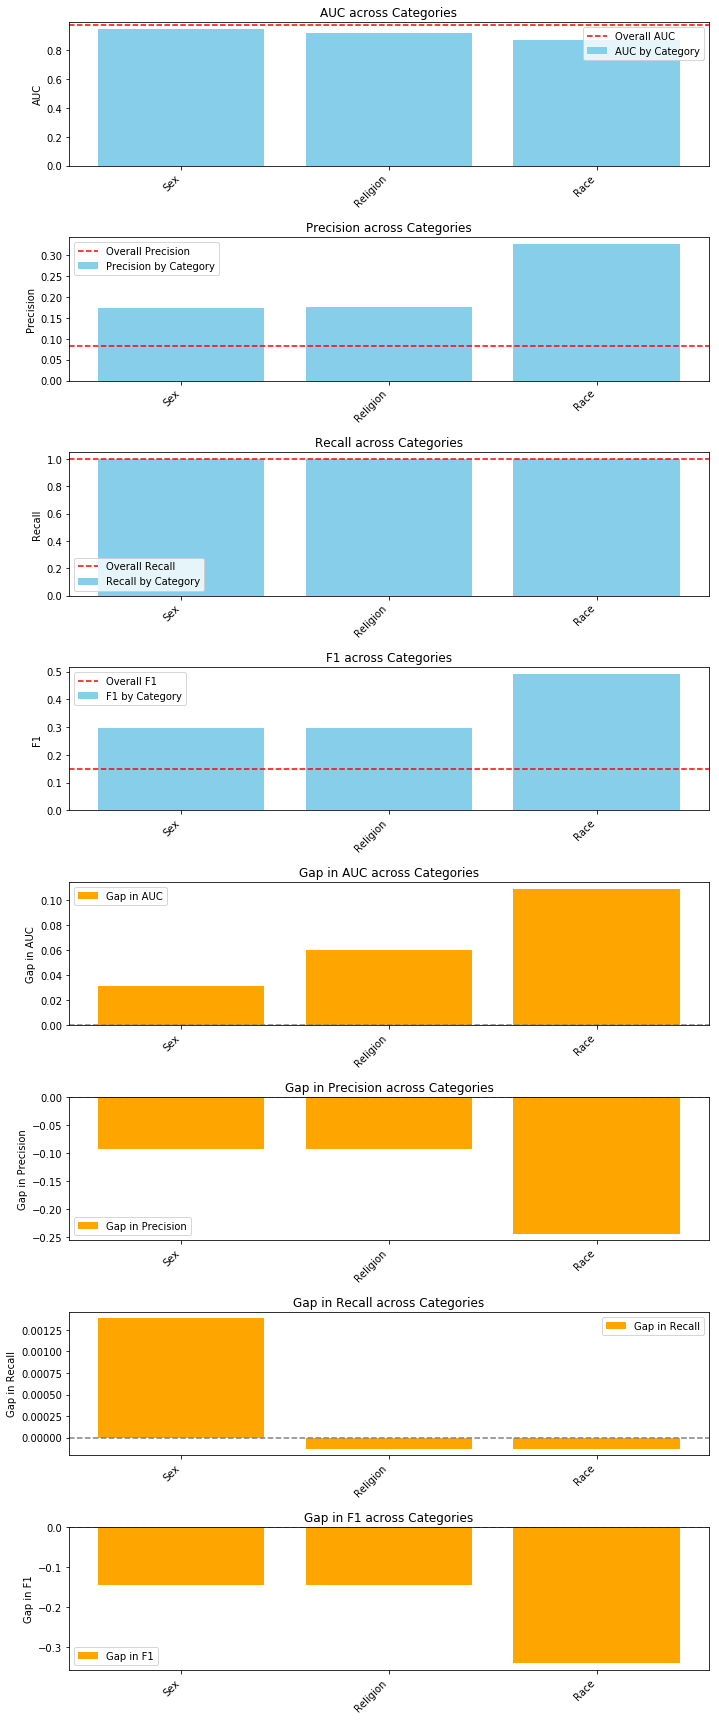

In [ ]:
def plot_metrics(category_metrics, gap_metrics):
    categories = list(category_metrics.keys())
    first_category = next(iter(category_metrics))
    first_subgroup = next(iter(category_metrics[first_category]))
    metrics = list(category_metrics[first_category][first_subgroup].keys())

    total_metrics = len(metrics)
    fig, axs = plt.subplots(total_metrics * 2, 1, figsize=(10, 6 * total_metrics))

    # Plotting the original metrics
    for i, metric in enumerate(metrics):
        category_avg_values = []
        for category in categories:
            # Calculate average of metric across each category
            avg_metric = np.mean([sub_metrics[metric] for sub_metrics in category_metrics[category].values()])
            category_avg_values.append(avg_metric)

        axs[i].bar(categories, category_avg_values, color='skyblue', label=f'{metric} by Category')
        axs[i].set_ylabel(metric)
        axs[i].set_title(f"{metric} across Categories")
        axs[i].axhline(y=overall_metrics[metric], color='red', linestyle='--', label='Overall ' + metric)
        axs[i].legend()
        axs[i].set_xticklabels(categories, rotation=45, ha="right")

    # Plotting the gap metrics
    for j, metric in enumerate(metrics):
        gap_values = [gap_metrics[category][f'{metric} Gap'] for category in categories]
        axs[j + total_metrics].bar(categories, gap_values, color='orange', label=f'Gap in {metric}')
        axs[j + total_metrics].set_ylabel(f'Gap in {metric}')
        axs[j + total_metrics].set_title(f"Gap in {metric} across Categories")
        axs[j + total_metrics].axhline(y=0, color='gray', linestyle='--')
        axs[j + total_metrics].legend()
        axs[j + total_metrics].set_xticklabels(categories, rotation=45, ha="right")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

plot_metrics(category_metrics, gap_metrics)

# **4b) Analyze the fairness of the ADS**

In [ ]:
from sklearn.metrics import confusion_matrix

def calculate_fairness_metrics(data, label_column, pred_column):
    overall_metrics = calculate_confusion_metrics(data, label_column, pred_column)

    table_data = []

    fairness_metrics = {}
    for category, subgroups in CATEGORIES.items():
        category_data = pd.DataFrame()

        # Aggregate data for the category
        for subgroup in subgroups:
            subgroup_data = data[data[subgroup].fillna(False) > 0.5]
            category_data = pd.concat([category_data, subgroup_data])

        if category_data.empty:
            table_data.append([category, "No data available", "", "", ""])
            continue

        category_metrics = calculate_confusion_metrics(category_data, label_column, pred_column)

        # Calculate Fairness Metrics
        demographic_parity_difference = category_metrics['Positive Rate'] - overall_metrics['Positive Rate']
        equal_opportunity_difference = category_metrics['TPR'] - overall_metrics['TPR']
        equalized_odds_difference = (category_metrics['TPR'] - overall_metrics['TPR'], category_metrics['FPR'] - overall_metrics['FPR'])
        disparate_impact = category_metrics['Positive Rate'] / overall_metrics['Positive Rate'] if overall_metrics['Positive Rate'] != 0 else None

        fairness_metrics[category] = {
            'Demographic Parity Difference': demographic_parity_difference,
            'Equal Opportunity Difference': equal_opportunity_difference,
            'Equalized Odds Difference': equalized_odds_difference,
            'Disparate Impact': disparate_impact
        }

        table_data.append([
            category,
            f"DPD: {demographic_parity_difference:.4f}",
            f"EOD: {equal_opportunity_difference:.4f}",
            f"EOD (TPR): {equalized_odds_difference[0]:.4f}, FPR: {equalized_odds_difference[1]:.4f}",
            f"DI: {disparate_impact:.4f}" if disparate_impact is not None else "Undefined"
        ])

    print(tabulate(table_data, headers=["Category", "Demographic Parity Difference", "Equal Opportunity Difference", "Equalized Odds Difference", "Disparate Impact"], tablefmt="grid"))

    return fairness_metrics

def calculate_confusion_metrics(data, label_column, pred_column):
    """ Helper function to calculate TPR, FPR, and other metrics from confusion matrix. """
    cm = confusion_matrix(data[label_column], data[pred_column] >= 0.5)
    TN, FP, FN, TP = cm.ravel()

    TPR = TP / (TP + FN) if TP + FN != 0 else 0  # True Positive Rate
    FPR = FP / (TN + FP) if TN + FP != 0 else 0  # False Positive Rate
    positive_rate = (TP + FP) / len(data) if len(data) != 0 else 0  # Rate of positive predictions

    return {
        'TPR': TPR,
        'FPR': FPR,
        'Positive Rate': positive_rate
    }

fairness_metrics = calculate_fairness_metrics(test_expanded, 'toxicity_class', 'model_probability')

+------------+---------------------------------+--------------------------------+----------------------------------+--------------------+
| Category   | Demographic Parity Difference   | Equal Opportunity Difference   | Equalized Odds Difference        | Disparate Impact   |
+============+=================================+================================+==================================+====================+
| Sex        | DPD: -0.1670                    | EOD: -0.0015                   | EOD (TPR): -0.0015, FPR: -0.1956 | DI: 0.8296         |
+------------+---------------------------------+--------------------------------+----------------------------------+--------------------+
| Religion   | DPD: -0.0751                    | EOD: 0.0001                    | EOD (TPR): 0.0001, FPR: -0.0902  | DI: 0.9233         |
+------------+---------------------------------+--------------------------------+----------------------------------+--------------------+
| Race       | DPD: 0.0033        

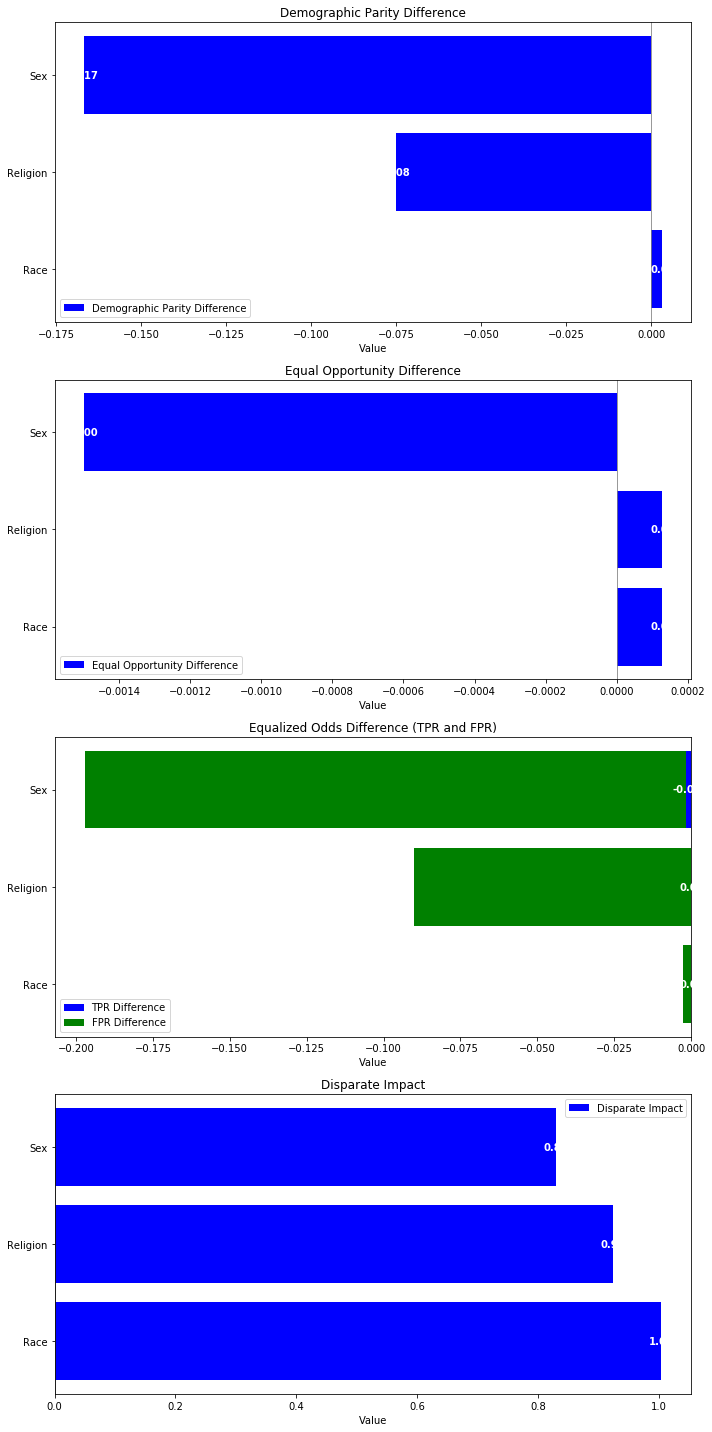

In [ ]:
def plot_fairness_metrics(fairness_metrics):
    category = next(iter(fairness_metrics))
    metrics = list(fairness_metrics[category].keys())
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(10, 5 * n_metrics))

    categories = list(fairness_metrics.keys())  # List categories

    for i, metric in enumerate(metrics):
        # Prepare values for each metric across categories
        values = [fairness_metrics[category][metric] if metric != 'Equalized Odds Difference' else fairness_metrics[category][metric][0] for category in categories]

        if metric == 'Equalized Odds Difference':  # Special handling for Equalized Odds which has TPR and FPR components
            values_tpr = [fairness_metrics[category][metric][0] for category in categories]
            values_fpr = [fairness_metrics[category][metric][1] for category in categories]

            axes[i].barh(categories, values_tpr, color='blue', label='TPR Difference')
            axes[i].barh(categories, values_fpr, left=values_tpr, color='green', label='FPR Difference')
            axes[i].set_title('Equalized Odds Difference (TPR and FPR)')
        else:
            axes[i].barh(categories, values, color='blue', label=metric.replace('_', ' ').title())
            axes[i].set_title(metric.replace('_', ' ').title())

        axes[i].axvline(0, color='gray', linewidth=0.8)
        axes[i].set_xlabel('Value')
        axes[i].invert_yaxis()
        for j, value in enumerate(values):
            axes[i].text(value, j, f'{value:.2f}', ha='center', va='center', color='white', fontweight='bold')

        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_fairness_metrics(fairness_metrics)

# **4c) Develop additional methods to analyze ADS performance:**

In [ ]:
import pandas as pd

CATEGORIES = {
    'Sex': ['male', 'female'],
    'Religion': ['christian', 'jewish', 'muslim'],
    'Race': ['black', 'white']
}

def get_top_comments(data, text_column, target_column, x, category, subgroup=None):
    """
    Retrieves the top X comment texts from a DataFrame based on a score, optionally filtering by category subgroup.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        text_column (str): The name of the column containing the text of the comments.
        target_column (str): The name of the column containing the scores.
        x (int): The number of top comments to return.
        category (str): The category to filter by (e.g., 'Sex', 'Religion', 'Race').
        subgroup (str, optional): The specific subgroup within the category to filter by (e.g., 'male', 'female').
                                   If not specified, comments from all subgroups in the category are considered.

    Returns:
        pd.DataFrame: A DataFrame containing the top X comments based on the score.
    """
    if category in CATEGORIES:
        if subgroup:
            if subgroup in CATEGORIES[category]:
                # Filter data by the specific subgroup
                filtered_data = data[data[subgroup] > 0.5]
            else:
                raise ValueError("Invalid subgroup specified for the given category")
        else:
            # Filter data by any subgroup within the category
            filtered_data = data[data[CATEGORIES[category]].sum(axis=1) > 0.5]

        sorted_data = filtered_data.sort_values(by=target_column, ascending=False)
        top_comments = sorted_data.head(x)
        for index, row in top_comments.iterrows():
            print(f"{row['comment_text']}\n")
        return top_comments[[text_column, target_column]]
    else:
        raise ValueError("Invalid category specified")

print("Most toxic comments in the Sex category:")
sex_comments = get_top_comments(test_expanded, 'comment_text', 'model_probability', 5, 'Sex')

print(f"\nMost toxic comments in the Male subgroup:")
sex_comments = get_top_comments(test_expanded, 'comment_text', 'model_probability', 3, 'Sex', 'male')

print(f"\nMost toxic comments in the Female subgroup:")
sex_comments = get_top_comments(test_expanded, 'comment_text', 'model_probability', 3, 'Sex', 'female')

print("Most toxic comments in the Race category:")
race_comments = get_top_comments(test_expanded, 'comment_text', 'model_probability', 5, 'Race')

print("Most toxic comments in the Black subgroup:")
race_comments = get_top_comments(test_expanded, 'comment_text', 'model_probability', 3, 'Race', 'black')

print("Most toxic comments in the White subgroup:")
race_comments = get_top_comments(test_expanded, 'comment_text', 'model_probability', 3, 'Race', 'white')

print("Most toxic comments in the Religion category:")
religion_comments = get_top_comments(test_expanded, 'comment_text', 'model_probability', 5, 'Religion')

Most toxic comments in the Sex category:
He is a sawed off berkely idiot with little man syndrome. Just the facts

The man is a total idiot and a buffoon.  I can't believe he doesn't look in the mirror and start laughing.  Of course, he has no sense of humor so he probably doesn't ever laugh.

here is the stupidest man on the planet, and his puppet, eh Butts. $#@! up Ontario and a national disgrace as well. Admit it, you are an idiot, proved it in Ontario under lying Dalton and just moved to the National stage.

Jay whatever is a dick - he should stay in the US instead of coming back a failure with his tail between his legs - the other guy is just another ron mclean playing the straight man to the dick sitting next to him - both are complete morons and not welcome back

You want 'malignant'?  How about holding up a decapitated effigy of the President and Democrats think it's a hoot?
How about producing plays where the President is assassinated and the left goes wild?
How about a Democr